In [1]:
# Numpy + plotting utilities + ordered dicts
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


# Standard PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Neuromancer imports
from neuromancer.psl.coupled_systems import *
from neuromancer.dynamics import integrators, ode, physics, interpolation
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.system import Node, System
from neuromancer.loggers import BasicLogger
from neuromancer.trainer import Trainer

# Fix seeds for reproducibility
np.random.seed(200)
torch.manual_seed(0)

# Integrating the BOPTEST data

In [2]:
from bospy import bos

In [3]:
fcu_pts = bos.QueryPoints(parent_types="brick:Fan_Coil_Unit")
for p in fcu_pts:
    name = bos.GetName(p)
    print(f"{name}\t = \'{p}\'")

zone_temp	 = 'bos://localhost/dev/12/pts/1'
solar_irradiance	 = 'bos://localhost/dev/12/pts/10'
wind_speed	 = 'bos://localhost/dev/12/pts/11'
cooling_override	 = 'bos://localhost/dev/12/pts/12'
heating_override	 = 'bos://localhost/dev/12/pts/13'
fan_override	 = 'bos://localhost/dev/12/pts/14'
flow_setpoint	 = 'bos://localhost/dev/12/pts/15'
supply_temp_override	 = 'bos://localhost/dev/12/pts/16'
zone_clg_stpt	 = 'bos://localhost/dev/12/pts/2'
zone_htg_stpt	 = 'bos://localhost/dev/12/pts/3'
sa_temp_stpt	 = 'bos://localhost/dev/12/pts/4'
oa_temp	 = 'bos://localhost/dev/12/pts/5'
air_flow	 = 'bos://localhost/dev/12/pts/6'
cooling_power	 = 'bos://localhost/dev/12/pts/7'
heating_power	 = 'bos://localhost/dev/12/pts/8'
fan_power	 = 'bos://localhost/dev/12/pts/9'


Get OA, SA, Zone Temp. Resample so we have the same number of each. 

In [4]:
oa = 'bos://localhost/dev/12/pts/5'
sa = 'bos://localhost/dev/12/pts/4'
za = 'bos://localhost/dev/12/pts/1'
stpt = 'bos://localhost/dev/12/pts/3'
solar = 'bos://localhost/dev/12/pts/10'
fan = 'bos://localhost/dev/12/pts/6'

In [5]:
pts = [oa, sa, za, stpt, solar, fan]
df = bos.GetHistory(pts,
               start='2025/1/1T00:00:00-06',
               end='2025/1/8T24:00:00-06',
               pandas=True, tz='America/Denver')
nsim = df.shape[0]
labels = [bos.GetName(p) for p in pts]
print(labels)
df.head()

['oa_temp', 'sa_temp_stpt', 'zone_temp', 'zone_htg_stpt', 'solar_irradiance', 'air_flow']


,bos://localhost/dev/12/pts/1,bos://localhost/dev/12/pts/10,bos://localhost/dev/12/pts/3,bos://localhost/dev/12/pts/4,bos://localhost/dev/12/pts/5,bos://localhost/dev/12/pts/6
time,,,,,,
2024-12-31 23:00:00-07:00,290.405090,0.0,288.149994,294.149994,273.149994,0.0
2024-12-31 23:15:00-07:00,290.253510,0.0,288.149994,294.149994,273.149994,0.0
2024-12-31 23:30:00-07:00,290.115723,0.0,288.149994,294.149994,273.149994,0.0
2024-12-31 23:45:00-07:00,289.987946,0.0,288.149994,294.149994,273.149994,0.0
2025-01-01 00:00:00-07:00,289.867096,0.0,288.149994,294.149994,273.149994,0.0


rescale solar gains to the range of temperatures

In [6]:
# _min = min(df[[oa, sa, za, stpt]].min())
# _max = max(df[[oa, sa, za, stpt]].max())
# print(_min, _max)

In [7]:
# For numpy arrays or pandas Series
def normalize_to_range(data, new_min=275, new_max=325):
    old_min, old_max = data.min(), data.max()
    return (data - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

In [8]:
df[solar] = normalize_to_range(df[solar])
df[fan] = normalize_to_range(df[fan])

<Axes: xlabel='time'>

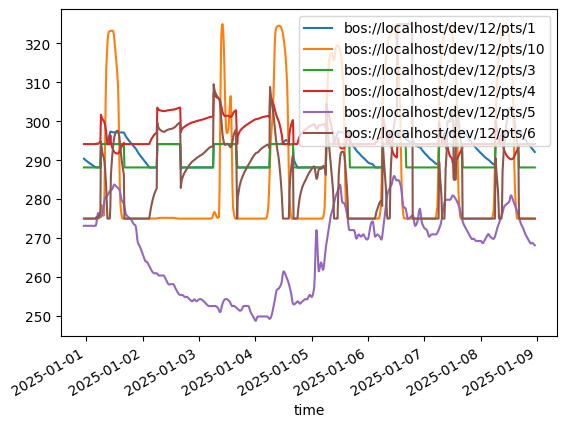

In [9]:
df.plot()

In [28]:
total_length = df.shape[0]
nstep = 96
n_sequences = total_length // nstep
truncated_length = n_sequences * nstep
print(total_length, nstep, n_sequences, truncated_length)

train_end = int(4/7 * truncated_length)
dev_end = int(6/7 * truncated_length)

df_truncated = df.iloc[:truncated_length]

train_df = df_truncated.iloc[:train_end]
dev_df = df_truncated.iloc[train_end:dev_end]
test_df = df_truncated.iloc[dev_end:]

U_names = [sa, stpt, fan, oa, solar]
# predicting zone_air_temp given outdoor air, supply air, and solar heat gain
train_data = {'Y': train_df[za].values, 'X': train_df[za].values, 'U': train_df[U_names].values}
dev_data = {'Y': dev_df[za].values, 'X': dev_df[za].values, 'U': dev_df[U_names].values}
test_data = {'Y': test_df[za].values, 'X': test_df[za].values, 'U': test_df[U_names].values}

# Calculate expected sequences for each split
train_sequences = len(train_df) // nstep
dev_sequences = len(dev_df) // nstep
test_sequences = len(test_df) // nstep

print(f"Train sequences: {train_sequences}, Dev sequences: {dev_sequences}, Test sequences: {test_sequences}")

# Reshape with explicit dimensions (not -1)
for d, n_seq in zip([train_data, dev_data], [train_sequences, dev_sequences]):
    d['X'] = d['X'][:n_seq * nstep].reshape(n_seq, nstep, 1)
    d['Y'] = d['Y'][:n_seq * nstep].reshape(n_seq, nstep, 1)
    d['U'] = d['U'][:n_seq * nstep].reshape(n_seq, nstep, len(U_names))
    d['xn'] = d['X'][:, 0:1, :]  # Note: added the missing dimension

train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]

train_loader = DataLoader(train_dataset, batch_size=min(32, train_sequences), collate_fn=train_dataset.collate_fn, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=min(32, dev_sequences), collate_fn=dev_dataset.collate_fn, shuffle=False)
# test_loader = DataLoader(dev_dataset, batch_size=dev_sequences, collate_fn=dev_dataset.collate_fn, shuffle=False)  # Placeholder

1078 96 11 1056
Train sequences: 6, Dev sequences: 3, Test sequences: 1


In [29]:
# zone connected to heater, outside air and solar gains.
adj = np.array([[0, 1], # inside to supply air 
                [0, 2], # inside to supply air 
                [0, 3],
                [0, 4],
                [0, 5]]).T  

zones = [physics.RCNode(C=nn.Parameter(torch.tensor(5.0)), scaling=1.0e-5)]

heaters = [physics.SourceSink(), physics.SourceSink(), physics.SourceSink()] # supply air, supply air set point, fan flow

# outdoor air and solar heat gains (normalized)
outside = [physics.SourceSink(), physics.SourceSink()]  

# join lists:
agents = zones + heaters + outside
print(f"Agents: {len(agents)} (zone=0, sa=1, sa_stpt=2, fan_flow=3, outside_air=4, solar_gains=5)")
adj

Agents: 6 (zone=0, sa=1, sa_stpt=2, fan_flow=3, outside_air=4, solar_gains=5)


array([[0, 0, 0, 0, 0],
       [1, 2, 3, 4, 5]])

In [30]:
map = physics.map_from_agents(agents)
# Let's take a look at this 'map':
print(map)

[OrderedDict({'T': 0}), OrderedDict({'T': 1}), OrderedDict({'T': 2}), OrderedDict({'T': 3}), OrderedDict({'T': 4}), OrderedDict({'T': 5})]


In [31]:
couplings = []

# couple to supply air temp
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,1]]))

# Couple to supply air temp set point
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,2]]))

# Couple to supply fan flow
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,3]]))

# Couple to oa
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,4]]))

# Couple to solar_gains:
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,5]]))

print(len(couplings))

5


In [32]:
# # Helper function for constructing couplings based on desired edge physics and an edge list:
# def generate_parameterized_edges(physics,edge_list):
#     """
#     Quick helper function to construct edge physics/objects from adj. list:
#     """

#     couplings = []
#     if isinstance(physics,nn.Module): # is "physics" an instance or a class?
#         # If we're in here, we expect one instance of "physics" for all edges in edge_list (homogeneous edges)
#         physics.pins = edge_list
#         couplings.append(physics)
#         print(f'Broadcasting {physics} to all elements in edge list.')
#     else: 
#         # If we're in here, we expect different "physics" for each edge in edge_list (heterogeneous edges)
#         for edge in edge_list:
#             agent = physics(R=nn.Parameter(torch.tensor(50.0)),pins=[edge])
#             couplings.append(agent)

#         print(f'Assuming new {physics} for each element in edge list.')

#     return couplings

# for a single node network. This is not needed. We can do it manually.
# couplings = generate_parameterized_edges(physics.DeltaTemp,list(adj.T))    # Heterogeneous edges of same physics

# Let's take a look at one:
# print(couplings[0])
# # What's it connecting?
# print(couplings[0].pins)


In [33]:
# Update your model configuration
nx = train_data['X'].shape[2]  # Should be 1 (single state; zone temp)
nu = train_data['U'].shape[2]  # Should be 2 (oa, sa inputs)
print(nx, nu)

model_ode = ode.GeneralNetworkedODE(
    map = map,
    agents = agents,
    couplings = couplings,
    insize = nx + nu,  
    outsize = nx,      
    inductive_bias="compositional")

fx_int = integrators.RK2(model_ode, h=1.0)

dynamics_model = System([Node(fx_int,['xn','U'],['xn'])])

1 5


In [34]:
# Verify your data shapes match the model
print("\nData shape verification:")
print(f"X shape: {train_data['X'].shape}")  # Should be (..., 1)
print(f"U shape: {train_data['U'].shape}")  # Should be (..., 2)
print(f"Model expects {model_ode.insize} inputs, {model_ode.outsize} outputs")


Data shape verification:
X shape: (6, 96, 1)
U shape: (6, 96, 5)
Model expects 6 inputs, 1 outputs


In [35]:
x = variable("X")
xhat = variable("xn")[:, :-1, :]

# reference_loss = ((xhat == x)^2)
# reference_loss = ((xhat - x) ** 2).minimize(weight=1.0)
reference_loss = ((xhat[:, :-1, :] - x[:, 1:, :]) ** 2).minimize(weight=1.0)
reference_loss.name = "ref_loss"

objectives = [reference_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

# Parameter constraining function
def constrain_physics_parameters():
    with torch.no_grad():
        for name, param in model_ode.named_parameters():
            if 'C' in name:
                param.data = torch.clamp(param.data, min=0.1)
                print(f"Constrained {name} to {param.data.item():.6f}")

# Constrain parameters before training
constrain_physics_parameters()

optimizer = torch.optim.Adam(problem.parameters(), lr=1.0)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=["dev_loss","train_loss"])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    epochs=1000,
    patience=20,
    warmup=5,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

Constrained agents.0.C to 5.000000
None
Number of parameters: 6


In [36]:
# best_model = trainer.train()

In [37]:
# # Create a trainer with parameter constraints
# class ConstrainedTrainer(Trainer):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
    
#     def training_step(self, batch):
#         # Do normal training step
#         output = super().training_step(batch)
        
#         # Constrain parameters after each step
#         with torch.no_grad():
#             for name, param in self.problem.parameters():
#                 if 'C' in name:
#                     param.data = torch.clamp(param.data, min=0.1)
                    
#         return output

# # Use constrained trainer
# constrained_trainer = ConstrainedTrainer(
#     problem,
#     train_loader,
#     dev_loader,
#     test_data,
#     optimizer,
#     epochs=1000,
#     patience=20,
#     warmup=5,
#     eval_metric="dev_loss",
#     train_metric="train_loss",
#     dev_metric="dev_loss",
#     test_metric="dev_loss",
#     logger=logger,
# )

In [38]:
# new_model = constrained_trainer.train()

In [39]:
# Initialize parameters closer to your successful values
with torch.no_grad():
    for name, param in model_ode.named_parameters():
        if 'C' in name:
            param.data = torch.tensor(30.0 + 10.0 * torch.randn(1).item())  # ~30±10
        if 'R' in name:
            param.data = torch.tensor(50.0 + 25.0 * torch.randn(1).item())  # ~50±25

print("Initialized parameters:")
for name, param in model_ode.named_parameters():
    print(f"{name}: {param.data.item():.6f}")

Initialized parameters:
agents.0.C: 22.807425
couplings.0.R: 39.916412
couplings.1.R: 35.084118
couplings.2.R: 54.550911
couplings.3.R: 28.583136
couplings.4.R: 77.515106


In [47]:
# redefine optimizer
optimizer = torch.optim.Adam(problem.parameters(), lr=0.125)

# Better approach: Manual training loop with proper neural ODE loss
def train_neural_ode_manually():
    model_ode.train()
    
    for epoch in range(500):  # Start with fewer epochs
        epoch_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            # Extract data
            x_true = batch['X']  # (batch, time, 1)
            u_seq = batch['U']   # (batch, time, nu) 
            x0 = batch['xn']     # (batch, 1, 1) - initial conditions
            
            batch_size, seq_len = x_true.shape[0], x_true.shape[1]
            
            # Manual integration
            x_pred = torch.zeros_like(x_true)
            x_pred[:, 0:1, :] = x0  # Set initial condition
            
            for t in range(seq_len - 1):
                # Current state and input
                x_current = x_pred[:, t:t+1, :].squeeze(1)  # (batch, 1)
                u_current = u_seq[:, t, :]                  # (batch, 2)
                
                # One integration step
                x_next = fx_int(x_current, u_current)       # (batch, 1)
                x_pred[:, t+1:t+2, :] = x_next.unsqueeze(1)
            
            # Compute loss
            mse_loss = torch.nn.functional.mse_loss(x_pred, x_true)
            
            # Backward pass
            mse_loss.backward()
            
            # Constrain parameters
            with torch.no_grad():
                for name, param in model_ode.named_parameters():
                    if 'C' in name:
                        param.data = torch.clamp(param.data, min=0.1)
                    if 'R' in name:
                        param.data = torch.clamp(param.data, min=0.1)
            
            optimizer.step()
            epoch_loss += mse_loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch}: Loss = {avg_loss:.6f}", end=" ")
        
        # Check parameters
        for name, param in model_ode.named_parameters():
            print(f"  {name}: {param.data.item():.6f}", end=" ")
        print()
        
        if avg_loss < 0.1:  # Good enough
            break

# Try manual training
train_neural_ode_manually()

Epoch 0: Loss = 2.962310   agents.0.C: 65.872406   couplings.0.R: 61.051670   couplings.1.R: 139.304703   couplings.2.R: -0.025000   couplings.3.R: 12.757700   couplings.4.R: 7.766954 
Epoch 1: Loss = 2.960892   agents.0.C: 65.997429   couplings.0.R: 60.928593   couplings.1.R: 139.429733   couplings.2.R: 0.016243   couplings.3.R: 12.849669   couplings.4.R: 7.857453 
Epoch 2: Loss = 2.959306   agents.0.C: 66.122383   couplings.0.R: 60.808918   couplings.1.R: 139.554703   couplings.2.R: -0.002262   couplings.3.R: 12.899632   couplings.4.R: 7.915146 
Epoch 3: Loss = 2.957787   agents.0.C: 66.247231   couplings.0.R: 60.699631   couplings.1.R: 139.679581   couplings.2.R: 0.016233   couplings.3.R: 12.876458   couplings.4.R: 7.901274 
Epoch 4: Loss = 2.956532   agents.0.C: 66.371994   couplings.0.R: 60.597202   couplings.1.R: 139.804398   couplings.2.R: 0.002762   couplings.3.R: 12.820290   couplings.4.R: 7.852614 
Epoch 5: Loss = 2.954596   agents.0.C: 66.496704   couplings.0.R: 60.495171   

In [41]:
# with torch.no_grad():
#     for name, param in model_ode.named_parameters():
#         if 'R' in name:
#             # Lower thermal resistance = higher heat transfer = larger temperature swings
#             param.data *= 0.5  # Reduce resistance by 50%
#         if 'C' in name:
#             # Lower thermal mass = faster temperature response = larger swings  
#             param.data *= 0.7  # Reduce capacitance by 30%

In [48]:
# Check parameters
for name, param in model_ode.named_parameters():
    print(f"  {name}: {param.data.item():.6f}", end=" ")
print()

  agents.0.C: 114.055611   couplings.0.R: 23.076078   couplings.1.R: 187.299713   couplings.2.R: 0.017744   couplings.3.R: 3.945136   couplings.4.R: 2.471040 


5


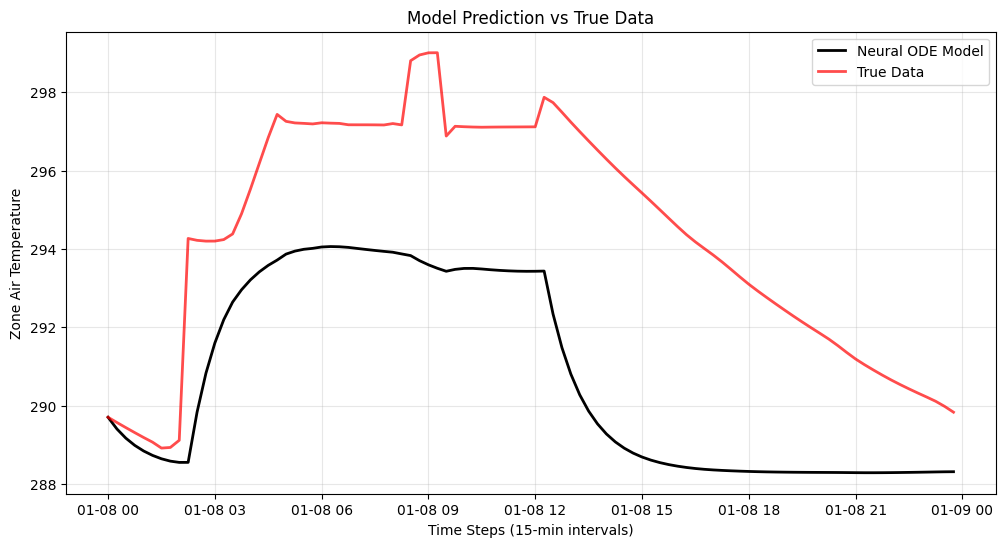

In [49]:
from datetime import datetime, timedelta
print(nu)
date = datetime.now().date()
start_date = datetime(year=date.year, month=1, day=8)
ts = [start_date + timedelta(minutes=i*15) for i in range(96)]
# Add test_data to your reshaping loop
test_sequences = len(test_df) // nstep

# Reshape test data like you did for train/dev
test_data['X'] = test_data['X'][:test_sequences * nstep].reshape(test_sequences, nstep, nx)
test_data['Y'] = test_data['Y'][:test_sequences * nstep].reshape(test_sequences, nstep, nx)
test_data['U'] = test_data['U'][:test_sequences * nstep].reshape(test_sequences, nstep, nu)

# Now flatten for plotting (take first sequence or concatenate all)
test_data_flat = {
    'X': test_data['X'].reshape(-1, nx),  # Flatten back to (time_steps, 1)
    'Y': test_data['Y'].reshape(-1, nx),
    'U': test_data['U'].reshape(-1, nu)
}

# Updated plotting code
u = torch.from_numpy(test_data_flat['U']).float()
sol = torch.zeros((len(test_data_flat['X']), nx))
ic = torch.tensor(test_data_flat['X'][0])  # Remove the second index

for j in range(sol.shape[0]-1):
    if j == 0:
        sol[0, :] = ic.float()
        sol[j+1, :] = fx_int(sol[j:j+1, :], u[j:j+1, :])
    else:
        sol[j+1, :] = fx_int(sol[j:j+1, :], u[j:j+1, :])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ts, sol.detach().numpy(), label='Neural ODE Model', color='black', linewidth=2)
plt.plot(ts, test_data_flat['X'], label='True Data', color='red', linewidth=2, alpha=0.7)
plt.xlabel('Time Steps (15-min intervals)')
plt.ylabel('Zone Air Temperature')
plt.title('Model Prediction vs True Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# # Add this during training to see gradient magnitudes
# def check_gradients():
#     print("Gradient magnitudes:")
#     for name, param in model_ode.named_parameters():
#         if param.grad is not None:
#             grad_norm = param.grad.data.norm().item()
#             print(f"  {name}: {grad_norm:.8f}")
            
# # Call this after loss.backward() during training

In [ ]:
# # Debug what's happening in the forward pass
# sample_batch = next(iter(train_loader))

# print("Input batch:")
# print(f"  Initial state (xn): {sample_batch['xn'][0, 0, 0].item():.3f}")
# print(f"  True trajectory (X): {sample_batch['X'][0, :5, 0]}")
# print(f"  Inputs (U): {sample_batch['U'][0, :3, :]}")

# with torch.no_grad():
#     model_output = dynamics_model(sample_batch)
#     predictions = model_output['xn'][0, :, 0]  # First sequence
    
#     print(f"\nModel predictions: {predictions[:10]}")
#     print(f"Are predictions constant? {torch.allclose(predictions, predictions[0], atol=1e-6)}")
#     print(f"Prediction range: {predictions.min():.3f} to {predictions.max():.3f}")
#     print(f"True data range: {sample_batch['X'][0, :, 0].min():.3f} to {sample_batch['X'][0, :, 0].max():.3f}")

In [ ]:
# Check if parameters are actually changing during training
print("Parameters before training:")
for name, param in model_ode.named_parameters():
    print(f"{name}: {param.data.item():.6f}")

# Check one training step manually
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
for k, v in sample_batch.items():
    print(f"  {k}: {v.shape}")

# Manual training step
optimizer.zero_grad()
output = problem(sample_batch)
print(f"Loss output: {output}")

if 'loss' in output:
    output['loss'].backward()
    
    # Check gradients
    print("\nGradients:")
    for name, param in model_ode.named_parameters():
        if param.grad is not None:
            print(f"{name} grad: {param.grad.data.item():.8f}")
        else:
            print(f"{name} grad: None")
    
    optimizer.step()
    
    print("\nParameters after one step:")
    for name, param in model_ode.named_parameters():
        print(f"{name}: {param.data.item():.6f}")

In [ ]:
# Check what's in the batch first
print("Sample batch contents:")
for k, v in sample_batch.items():
    print(f"  {k}: type={type(v)}, value={v if isinstance(v, str) else 'tensor'}")
    if hasattr(v, 'shape'):
        print(f"    shape: {v.shape}")

# The main issue: NEGATIVE CAPACITANCE AGAIN!
print(f"\n⚠️ NEGATIVE CAPACITANCE: {-0.009870}")
print("This explains the flat line - fixing this first...")

# Fix the negative capacitance immediately
with torch.no_grad():
    for name, param in model_ode.named_parameters():
        if 'C' in name:
            param.data = torch.tensor(5.0)  # Set to positive value
            print(f"Fixed {name}: {param.data.item()}")

# Test if fixing capacitance helps
ic = torch.tensor([[296.1441]], dtype=torch.float32)
u_test = torch.tensor([[277.7881, 294.1500]], dtype=torch.float32)

with torch.no_grad():
    derivative = model_ode(ic, u_test)
    print(f"With positive capacitance, derivative: {derivative.item():.6f}")

# Now try a proper training step
try:
    # Get a fresh batch
    sample_batch = next(iter(train_loader))
    
    # Filter out any non-tensor items
    tensor_batch = {k: v for k, v in sample_batch.items() if hasattr(v, 'shape')}
    
    print(f"\nFiltered batch shapes:")
    for k, v in tensor_batch.items():
        print(f"  {k}: {v.shape}")
    
    # Manual training step
    optimizer.zero_grad()
    output = problem(tensor_batch)
    print(f"Problem output: {output}")
    
    if 'loss' in output and hasattr(output['loss'], 'backward'):
        loss_value = output['loss']
        print(f"Loss value: {loss_value.item():.6f}")
        
        loss_value.backward()
        
        # Check gradients
        print("\nGradients:")
        for name, param in model_ode.named_parameters():
            if param.grad is not None:
                print(f"{name} grad: {param.grad.data.item():.8f}")
            else:
                print(f"{name} grad: None")
        
        optimizer.step()
        
        # Constrain parameters after step
        with torch.no_grad():
            for name, param in model_ode.named_parameters():
                if 'C' in name:
                    param.data = torch.clamp(param.data, min=0.1)
        
        print("\nParameters after one step:")
        for name, param in model_ode.named_parameters():
            print(f"{name}: {param.data.item():.6f}")
            
except Exception as e:
    print(f"Training step failed: {e}")
    
    # Try to diagnose the data loader
    print("\nInvestigating data loader...")
    for i, batch in enumerate(train_loader):
        print(f"Batch {i}: {batch}")
        if i > 2:  # Just check first few batches
            break

In [ ]:
# Check if model parameters changed during training
print("Model parameters after training:")
for name, param in model_ode.named_parameters():
    print(f"{name}: {param.data}")
    
# Check training/validation loss curves
# (You should have seen these decreasing during training)

In [ ]:
# Check the model's step size - this might be too large/small
print(f"Integration step size (h): {fx_int.h}")

# Test what the model actually outputs for a single step
ic = torch.tensor([[test_data_flat['X'][0]]], dtype=torch.float32)
u_test = torch.tensor(test_data_flat['U'][0:1], dtype=torch.float32)

print(f"Initial condition: {ic}")
print(f"Test input: {u_test}")

# Test the ODE function directly
with torch.no_grad():
    ode_output = model_ode(ic, u_test)
    print(f"ODE derivative output: {ode_output}")
    
    # Test one integration step
    next_state = fx_int(ic, u_test)
    print(f"Next state after integration: {next_state}")
    print(f"Change: {(next_state - ic).item():.6f}")

In [ ]:
# Fix the tensor dimensions
ic = torch.tensor([[test_data_flat['X'][0]]], dtype=torch.float32)  # Shape: (1, 1) - 2D
u_test = torch.tensor([test_data_flat['U'][0]], dtype=torch.float32)  # Shape: (1, 2) - 2D

print(f"Initial condition shape: {ic.shape}, values: {ic}")
print(f"Test input shape: {u_test.shape}, values: {u_test}")

# Test the ODE function directly
with torch.no_grad():
    ode_output = model_ode(ic, u_test)
    print(f"ODE derivative output: {ode_output}")
    print(f"ODE output shape: {ode_output.shape}")
    
    # Test one integration step
    next_state = fx_int(ic, u_test)
    print(f"Next state after integration: {next_state}")
    print(f"Next state shape: {next_state.shape}")
    print(f"Change: {(next_state - ic).item():.6f}")

In [ ]:
# Fixed integration loop - convert numpy to torch
u = torch.from_numpy(test_data_flat['U']).float()  # Shape: (n_steps, 2)
x_true = torch.from_numpy(test_data_flat['X']).float()  # Convert to torch tensor
n_steps = len(x_true)

# Initialize
sol = torch.zeros((n_steps, 1))
sol[0, 0] = x_true[0]  # Now both are torch tensors

print(f"Starting from: {sol[0, 0]:.3f}")
print(f"U shape: {u.shape}")
print(f"x_true shape: {x_true.shape}")

with torch.no_grad():
    for j in range(min(20, n_steps - 1)):  # Test first 20 steps
        current_x = sol[j:j+1, :]  # Shape: (1, 1) - 2D
        current_u = u[j:j+1, :]    # Shape: (1, 2) - 2D
        
        # Debug shapes
        if j == 0:
            print(f"current_x shape: {current_x.shape}")
            print(f"current_u shape: {current_u.shape}")
        
        # Get next state
        next_x = fx_int(current_x, current_u)
        sol[j+1, :] = next_x
        
        # Debug first few steps
        if j < 10:
            print(f"Step {j}: {current_x.item():.3f} -> {next_x.item():.3f} (Δ={next_x.item()-current_x.item():.6f})")

# Plot first 20 steps to see if there's any movement
plt.figure(figsize=(12, 6))
plt.plot(sol[:20].detach().numpy(), 'o-', label='Model', color='black', linewidth=2)
plt.plot(x_true[:20].numpy(), 's-', label='True', color='red', linewidth=2, alpha=0.7)  # Convert to numpy for plotting
plt.xlabel('Time Steps')
plt.ylabel('Temperature (K)')
plt.title('First 20 steps - Model vs True')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Check if the model is making any meaningful changes
changes = torch.diff(sol[:20], dim=0)
print(f"Temperature changes in first 20 steps:")
print(f"Min change: {changes.min():.6f}")
print(f"Max change: {changes.max():.6f}")
print(f"Mean absolute change: {changes.abs().mean():.6f}")

In [ ]:
# Test the ODE function directly with proper 2D tensors
ic = torch.tensor([[test_data_flat['X'][0]]], dtype=torch.float32)  # Shape: (1, 1)
u_test = torch.tensor([test_data_flat['U'][0]], dtype=torch.float32)  # Shape: (1, 2)

print(f"Initial condition: {ic.item():.3f} K")
print(f"Inputs: outdoor={u_test[0,0].item():.3f} K, supply={u_test[0,1].item():.3f} K")

with torch.no_grad():
    # Test the ODE derivative
    derivative = model_ode(ic, u_test)
    print(f"Model derivative (dT/dt): {derivative.item():.6f} K/timestep")
    
    # What this means physically
    if abs(derivative.item()) < 1e-6:
        print("⚠️  Model is predicting almost zero change - this is the problem!")
    elif derivative.item() < 0:
        print(f"Model predicts cooling at {derivative.item():.6f} K/timestep")
    else:
        print(f"Model predicts heating at {derivative.item():.6f} K/timestep")

In [ ]:
# Let's see what the loss function was actually optimizing
print("\nLet's check a training batch:")

# Get a small batch from your training data
train_batch = next(iter(train_loader))
print(f"Training batch shapes:")
for key, value in train_batch.items():
    print(f"  {key}: {value.shape}")

with torch.no_grad():
    train_output = dynamics_model(train_batch)
    print(f"Model training output keys: {train_output.keys()}")
    
    # Check what the model actually predicted vs truth
    if 'xn' in train_output:
        pred = train_output['xn']
        true = train_batch['X']
        print(f"Prediction shape: {pred.shape}")
        print(f"True data shape: {true.shape}")
        
        # Compare first sequence, first few timesteps
        print(f"First sequence predictions vs truth:")
        for t in range(min(5, pred.shape[1], true.shape[1])):
            print(f"  t={t}: pred={pred[0,t,0].item():.3f}, true={true[0,t,0].item():.3f}")

In [ ]:
# Test a single forward pass
print("Input shapes:")
print(f"Initial condition: {ic.shape}, values: {ic}")
print(f"First input: {u[0].shape}, values: {u[0]}")

# Test the integrator directly
test_output = fx_int(ic.unsqueeze(0), u[0:1])
print(f"Single step output: {test_output}")
print(f"Output shape: {test_output.shape}")

In [ ]:
# Debug tensor shapes first
ic = torch.tensor([[test_data_flat['X'][0]]], dtype=torch.float32)
u_test = torch.tensor([test_data_flat['U'][0]], dtype=torch.float32)

print(f"ic shape: {ic.shape}")
print(f"ic: {ic}")
print(f"u_test shape: {u_test.shape}")
print(f"u_test: {u_test}")

# The issue might be that ic has too many brackets
# Let's try flattening it properly
ic_fixed = torch.tensor([test_data_flat['X'][0]], dtype=torch.float32).reshape(1, 1)
u_test_fixed = torch.tensor(test_data_flat['U'][0], dtype=torch.float32).reshape(1, 2)

print(f"\nFixed shapes:")
print(f"ic_fixed shape: {ic_fixed.shape}")
print(f"ic_fixed: {ic_fixed}")
print(f"u_test_fixed shape: {u_test_fixed.shape}")
print(f"u_test_fixed: {u_test_fixed}")

# Test with fixed tensors
with torch.no_grad():
    try:
        derivative = model_ode(ic_fixed, u_test_fixed)
        print(f"Model derivative (dT/dt): {derivative.item():.6f} K/timestep")
        
        if abs(derivative.item()) < 1e-6:
            print("⚠️  Model is predicting almost zero change - this is the problem!")
        elif derivative.item() < 0:
            print(f"Model predicts cooling at {derivative.item():.6f} K/timestep")
        else:
            print(f"Model predicts heating at {derivative.item():.6f} K/timestep")
            
    except Exception as e:
        print(f"Still failing: {e}")
        print("Let's check what model_ode expects...")
        
        # Let's see what the integrator is actually passing
        print("\nLet's test the integrator directly:")
        try:
            next_state = fx_int(ic_fixed, u_test_fixed)
            print(f"Integrator works! Next state: {next_state}")
            print(f"Change: {(next_state - ic_fixed).item():.6f}")
        except Exception as e2:
            print(f"Integrator also fails: {e2}")

In [ ]:
print("Detailed physics parameters:")
for name, param in model_ode.named_parameters():
    print(f"{name}: {param.data.item():.8f}")

# Let's check if the capacitance is too small
C_value = None
for name, param in model_ode.named_parameters():
    if 'C' in name:
        C_value = param.data.item()
        print(f"Capacitance C = {C_value:.8f}")
        if abs(C_value) < 1e-6:
            print("⚠️ Capacitance is extremely small - this kills thermal dynamics!")
        elif C_value < 0:
            print("⚠️ Negative capacitance - this is unphysical!")

In [ ]:
print("⚠️ NEGATIVE CAPACITANCE DETECTED!")
print("This is unphysical and breaks thermal dynamics")

# Test with manually corrected parameters
print("\nTesting with corrected positive capacitance:")

with torch.no_grad():
    # Fix the negative capacitance
    for name, param in model_ode.named_parameters():
        if 'C' in name:
            param.data = torch.tensor(5.0)  # Set to positive value
            print(f"Fixed {name}: {param.data.item()}")

# Test dynamics with corrected parameters
with torch.no_grad():
    derivative = model_ode(ic_fixed, u_test_fixed)
    print(f"With positive capacitance, derivative: {derivative.item():.6f} K/timestep")
    
    if abs(derivative.item()) > 1e-6:
        print("✅ Fixed! Now the model produces real thermal dynamics")
        
        # Test integration
        current_temp = ic_fixed.item()
        outdoor_temp = u_test_fixed[0, 0].item()
        supply_temp = u_test_fixed[0, 1].item()
        
        print(f"Physics check:")
        print(f"  Zone: {current_temp:.1f}K, Outdoor: {outdoor_temp:.1f}K, Supply: {supply_temp:.1f}K")
        
        if current_temp > outdoor_temp:
            print(f"  Zone is warmer than outdoor → should cool (derivative < 0)")
        else:
            print(f"  Zone is cooler than outdoor → should heat (derivative > 0)")
            
        if derivative.item() < 0:
            print(f"  ✅ Model predicts cooling: {derivative.item():.6f}")
        else:
            print(f"  ✅ Model predicts heating: {derivative.item():.6f}")

In [ ]:
# Option 1: Use parameter constraints
zones = [physics.RCNode(
    C=nn.Parameter(torch.tensor(5.0)), 
    scaling=1.0e-5
) for i in range(1)]

# Add this after creating the model but before training:
def constrain_parameters():
    """Ensure thermal capacitance stays positive"""
    with torch.no_grad():
        for name, param in model_ode.named_parameters():
            if 'C' in name:
                param.data = torch.clamp(param.data, min=0.1)  # Keep C >= 0.1

# Call this after each training step
# constrain_parameters()